Load Data

In [1]:
import pickle

def load_artifacts():
    """Loads the processed data artifacts from disk."""
    print("--- Loading system artifacts... ---")
    try:
        with open("./artifacts/cranfield_vectors.pkl", 'rb') as f:  
            doc_vectors = pickle.load(f)

        with open("./artifacts/cranfield_idf.pkl", 'rb') as f:
            idf_scores = pickle.load(f)
            
        print("Artifacts loaded successfully.")
        return doc_vectors, idf_scores
    except FileNotFoundError:
        print("Error: Could not find artifact files. Please run the '1_Index_Builder.ipynb' first.")
        return None, None

In [2]:
document_vectors, idf_scores =load_artifacts()

--- Loading system artifacts... ---
Artifacts loaded successfully.


Load queries

In [3]:
def load_queries(filepath):
    """
    Parses the Cranfield queries file (.qry) to extract query IDs and their text.

    The function reads the file line by line, identifying new queries by the '.I' marker
    and accumulating the query text that follows the '.W' marker.
    """
    # Initialize an empty dictionary to store the final query data
    queries = {}
    
    # Use -1 as a placeholder to indicate that we haven't started reading the first query yet.
    current_id = -1
    
    # Initialize an empty string to accumulate the text for the query being processed.
    current_text = ""
    
    # Open the specified file for reading.
    with open(filepath, 'r') as f:
        # Iterate over each line in the file.
        for line in f:
            # Check if the line marks the beginning of a new query
            if line.startswith('.I'):
                # If current_id is not -1, it means we have just finished reading a
                # previous query, and its text needs to be saved before we start the new one.
                if current_id != -1:
                    # Save the accumulated text. .strip() removes whitespace from the ends
                    queries[current_id] = current_text.strip()
                
                # Extract the new query ID from the line
                current_id = int(line.split()[1])
                
                # Reset the text accumulator to start fresh for this new query.
                current_text = ""
                
            # Check if the line is the '.W' marker, which indicates the start of the text.
            elif line.startswith('.W'):
                # This line is just a marker, so we don't need to do anything with it.
                pass
                
            # If the line is not a marker, it must be part of the query text.
            else:
                # Append the line to our accumulator for the current query.
                current_text += line
                
    # --- Final save after the loop ---
    # When the loop finishes, the text for the very last query is still in 'current_text'.
    # This final block ensures that the last query is also added to the dictionary.
    if current_id != -1:
        queries[current_id] = current_text.strip()
        
    # Return the completed dictionary of queries.
    return queries

In [4]:
queries =load_queries("./dataset/cran.qry")
    
# Print the first 3 queries to see if they look correct
for i in range(1, 5):
    if i in queries:
        print(f"Query ID {i}: {queries[i]}")

Query ID 1: what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .
Query ID 2: what are the structural and aeroelastic problems associated with flight
of high speed aircraft .
Query ID 4: what problems of heat conduction in composite slabs have been solved so
far .


Load relevance judgments

In [5]:
from collections import defaultdict

def load_relevance_judgments(filepath):
    """
    Parses the cranqrel file to load the ground truth relevance data.

    The function reads the file line by line, where each line contains a
    query ID, a relevant document ID, and a relevance score. It then
    organizes this data into a dictionary for easy lookup.
    """
    # Initialize a defaultdict with the default factory 'list'.
    qrels = defaultdict(list)
    
    # Open the specified file 
    with open(filepath, 'r') as f:
        # Iterate over each line in the file.
        for line in f:
            # Each line in cranqrel looks like: "1 184 2"
            # .split() will turn this string into a list of strings: ["1", "184", "2"]
            # map(int, ...) applies the int() function to each item in that list,
            # converting them into integers.
            # We then unpack these three integers into three variables.
            query_id, doc_id, relecance_score = map(int, line.split())
            
            if relecance_score > 0:
                # Use the query_id as the key and append the relevant doc_id to its list.
                 qrels[query_id].append(doc_id)
                
    # Return the completed dictionary of relevance judgments.
    return qrels

In [6]:
relevance_data = load_relevance_judgments("./dataset/cranqrel")

print(f"\nLoaded {len(queries)} queries and relevance judgments for {len(relevance_data)} queries.")


Loaded 225 queries and relevance judgments for 225 queries.


Performance Metrics

In [7]:
def calculate_metrics(retrieved_docs, relevant_docs):
    """
    Calculates Precision, Recall, and F1-Score for a single query.
    """
    # Convert lists to sets for efficient intersection
    retrieved_set = set(retrieved_docs)
    relevant_set = set(relevant_docs)

    # True Positives are the documents that are in both lists
    true_positives = len(retrieved_set.intersection(relevant_set))

    # --- Precision --- 
    # Measures: "Of the documents our system returned, how many were actually relevant?"
    # P = (Number of relevant items retrieved) / (Total number of items retrieved)
    precision = true_positives / len(retrieved_docs) if retrieved_docs else 0.0

    # --- Recall --- 
    # Measures: "Of all the possible relevant documents, how many did our system find?"
    # R = (Number of relevant items retrieved) / (Total number of relevant items)
    recall = true_positives / len(relevant_docs) if relevant_docs else 0.0

    # --- F1-Score ---
    # The harmonic mean of Precision and Recall, balancing both metrics.
    f1_score = 0.0
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score
    }

In [8]:
# Run Full System Evaluation

from retrieval import preprocess_text, create_query_vector ,rank_documents
K = 10
all_metrics = []

print("--- Starting full evaluation... ---")

if document_vectors and queries and relevance_data:
    for query_id, query_text in queries.items():
        
        # --- Initial Query ---
        query_tokens = preprocess_text([query_text])[0]

        original_query_vector = create_query_vector(query_tokens, idf_scores)

        # --- Get Initial Ranking ---
        ranked_results = rank_documents(original_query_vector, document_vectors)


        # --- Calculate Metrics on the FINAL ranking ---
        retrieved_top_k_ids = [doc_id for doc_id, score in ranked_results[:K]]
        ground_truth_ids = relevance_data.get(query_id, [])
        query_metrics = calculate_metrics(retrieved_top_k_ids, ground_truth_ids)
        all_metrics.append(query_metrics)

print(f"Evaluation complete. Processed {len(all_metrics)} queries.")

--- Starting full evaluation... ---
Evaluation complete. Processed 225 queries.


In [9]:
# Check if the evaluation loop has produced any metrics
if all_metrics:
    # Calculate the average (mean) of each metric across all 225 queries
    mean_precision = sum(m['precision'] for m in all_metrics) / len(all_metrics)
    mean_recall = sum(m['recall'] for m in all_metrics) / len(all_metrics)
    mean_f1_score = sum(m['f1_score'] for m in all_metrics) / len(all_metrics)

    # Print a clean, formatted summary of the final results
    print("\n--- System Performance Summary ---")
    print("-" * 30)
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall:    {mean_recall:.4f}")
    print(f"Mean F1-Score:  {mean_f1_score:.4f}")
    print("-" * 30)
else:
    print("No metrics were calculated. Please ensure the evaluation loop ran correctly.")


--- System Performance Summary ---
------------------------------
Mean Precision: 0.0049
Mean Recall:    0.0029
Mean F1-Score:  0.0035
------------------------------


In [10]:
def evaluate_single_query(query_id, k, queries, relevance_data, document_vectors, idf_scores):
    """
    Runs the full retrieval and evaluation process for a single query ID
    and prints a detailed summary of the results.

    This is because our relevance judgments are not very good, for some queries we have for example
    4 documents that are relevant, and for another one it can be more than 10
    """
    # --- Check if the query exists ---
    if query_id not in queries:
        print(f"Error: Query ID {query_id} not found.")
        return

    # --- 1. Get Query and Ground Truth ---
    query_text = queries[query_id]
    ground_truth_ids = relevance_data.get(query_id, [])

    print("="*50)
    print(f"Evaluating Query ID: {query_id}")
    print(f"Query Text: '{query_text}'")
    print(f"Ground Truth Relevant Docs: {ground_truth_ids}")
    print("="*50)
    
    # --- 2. Process and Rank ---
    query_tokens = preprocess_text([query_text])[0]
    query_vector = create_query_vector(query_tokens, idf_scores)
    ranked_results = rank_documents(query_vector, document_vectors)

    # --- 3. Get Retrieved Docs and Calculate Metrics ---
    retrieved_top_k_ids = [doc_id for doc_id, score in ranked_results[:k]]
    
    # We already have a function for this!
    metrics = calculate_metrics(retrieved_top_k_ids, ground_truth_ids)

    # --- 4. Print Results ---
    print(f"Top {k} Retrieved Documents: {retrieved_top_k_ids}\n")
    
    print("--- Performance Metrics ---")
    print(f"Precision@{k}:   {metrics['precision']:.4f}")
    print(f"Recall@{k}:      {metrics['recall']:.4f}")
    print(f"F1-Score@{k}:    {metrics['f1_score']:.4f}")
    print("="*50)


In [26]:

evaluate_single_query(
    query_id=1, 
    k=20, 
    queries=queries, 
    relevance_data=relevance_data, 
    document_vectors=document_vectors, 
    idf_scores=idf_scores
)

Evaluating Query ID: 1
Query Text: 'what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .'
Ground Truth Relevant Docs: [184, 29, 31, 12, 51, 102, 13, 14, 15, 57, 378, 859, 185, 30, 37, 52, 142, 195, 875, 56, 66, 95, 462, 497, 858, 876, 879, 880]
Top 20 Retrieved Documents: [51, 943, 583, 664, 359, 816, 253, 435, 56, 12, 791, 873, 1167, 1192, 1147, 1142, 877, 817, 878, 662]

--- Performance Metrics ---
Precision@20:   0.1500
Recall@20:      0.1071
F1-Score@20:    0.1250


Evaluation with Pseudo-Relevance Feedback

In [12]:
# Run Full System Evaluation with Pseudo-Relevance Feedback

# import the updated functions 
from retrieval import preprocess_text, apply_rocchio_feedback,create_query_vector ,rank_documents

all_metrics_feedback = []
K = 10 # Evaluate Precision@10
N_FEEDBACK_DOCS = 3 # Assume top 3 documents are relevant for feedback

print("--- Starting full evaluation with Pseudo-Relevance Feedback... ---")

if document_vectors and queries and relevance_data:
    for query_id, query_text in queries.items():
        
        # --- Initial Query ---
        query_tokens = preprocess_text([query_text])[0]

        original_query_vector = create_query_vector(query_tokens, idf_scores)

        # --- Get Initial Ranking ---
        initial_ranked_results = rank_documents(original_query_vector, document_vectors)
        
        # --- Apply Pseudo-Relevance Feedback ---
        assumed_relevant_ids = [doc_id - 1 for doc_id, score in initial_ranked_results[:N_FEEDBACK_DOCS]]
        
        if not assumed_relevant_ids:
            final_ranked_results = initial_ranked_results
        else:
            #  Pass the `idf_scores` dictionary to the feedback function.
            modified_query_vector = apply_rocchio_feedback(
                original_query_vector,
                assumed_relevant_ids,
                [], # No non-relevant documents
                document_vectors,
                idf_scores,
                alpha=1.0, beta=0.75, gamma=0.0 
            )
            
            # Re-rank the documents using the modified query vector
            final_ranked_results = rank_documents(modified_query_vector, document_vectors)

        # --- Calculate Metrics on the FINAL ranking ---
        retrieved_top_k_ids = [doc_id for doc_id, score in final_ranked_results[:K]]
        ground_truth_ids = relevance_data.get(query_id, [])
        query_metrics = calculate_metrics(retrieved_top_k_ids, ground_truth_ids)
        all_metrics_feedback.append(query_metrics)

print(f"Evaluation complete. Processed {len(all_metrics_feedback)} queries.")

--- Starting full evaluation with Pseudo-Relevance Feedback... ---
Evaluation complete. Processed 225 queries.


In [13]:
# Check if the evaluation loop has produced any metrics
if all_metrics_feedback:
    # Calculate the average (mean) of each metric across all 225 queries
    mean_precision = sum(m['precision'] for m in all_metrics) / len(all_metrics)
    mean_recall = sum(m['recall'] for m in all_metrics) / len(all_metrics)
    mean_f1_score = sum(m['f1_score'] for m in all_metrics) / len(all_metrics)

    # Print a clean, formatted summary of the final results
    print("\n--- System Performance Summary ---")
    print("-" * 30)
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall:    {mean_recall:.4f}")
    print(f"Mean F1-Score:  {mean_f1_score:.4f}")
    print("-" * 30)
else:
    print("No metrics were calculated. Please ensure the evaluation loop ran correctly.")


--- System Performance Summary ---
------------------------------
Mean Precision: 0.0049
Mean Recall:    0.0029
Mean F1-Score:  0.0035
------------------------------


In [14]:
import math
def evaluate_single_query_with_feedback(query_id, k, n_feedback, queries, relevance_data, document_vectors, idf_scores):
    """
    Runs the full retrieval and evaluation process for a single query ID,
    including a pseudo-relevance feedback step, and prints a detailed summary.
    """
    # --- Check if the query exists ---
    if query_id not in queries:
        print(f"Error: Query ID {query_id} not found.")
        return

    # --- 1. Get Query and Ground Truth ---
    query_text = queries[query_id]
    ground_truth_ids = relevance_data.get(query_id, [])

    print("="*60)
    print(f"EVALUATING QUERY ID: {query_id}")
    print(f"Query Text: '{query_text}'")
    print(f"Ground Truth Relevant Docs: {ground_truth_ids}")
    print("="*60)
    
    # --- 2. Initial Search (Before Feedback) --- 
    query_tokens = preprocess_text([query_text])[0]
    original_query_vector = create_query_vector(query_tokens, idf_scores)
    initial_ranked_results = rank_documents(original_query_vector, document_vectors)

    print("\n--- Initial Top 5 Results (Before Feedback) ---")
    for rank, (doc_id, score) in enumerate(initial_ranked_results[:5], 1):
        print(f"Rank {rank}: Doc {doc_id} (Score: {score:.4f})")
    
    # --- 3. Apply Pseudo-Relevance Feedback ---
    print(f"\n--- Applying Pseudo-Relevance Feedback (using top {n_feedback} docs) ---")
    assumed_relevant_ids = [doc_id - 1 for doc_id, score in initial_ranked_results[:n_feedback]]
    
    if not assumed_relevant_ids:
        print("No initial results found, skipping feedback.")
        final_ranked_results = initial_ranked_results
    else:
        # Create the new, improved query vector using the Rocchio formula
        modified_query_vector = apply_rocchio_feedback(
            original_query_vector,
            assumed_relevant_ids,
            [], # No non-relevant documents for pseudo-feedback
            document_vectors,
            idf_scores,
            alpha=1.0, beta=0.75, gamma=0.0 # Gamma is 0
        )
        
        # **THE CRITICAL FIX:** Re-normalize the modified query vector to a length of 1.
        magnitude_squared = sum(weight**2 for weight in modified_query_vector.values())
        magnitude = math.sqrt(magnitude_squared)
        
        final_query_vector = {}
        if magnitude > 0:
            for term, weight in modified_query_vector.items():
                final_query_vector[term] = weight / magnitude

        # Re-rank the documents using the properly normalized modified query vector
        final_ranked_results = rank_documents(final_query_vector, document_vectors)

    # --- 4. Final Results and Metrics (After Feedback) ---
    print("\n--- Final Top 5 Results (After Feedback) ---")
    if not final_ranked_results:
        print("No documents found after feedback.")
    else:
        for rank, (doc_id, score) in enumerate(final_ranked_results[:k], 1):
            print(f"Rank {rank}: Doc {doc_id} (Score: {score:.4f})")
    
    retrieved_top_k_ids = [doc_id for doc_id, score in final_ranked_results[:k]]
    metrics = calculate_metrics(retrieved_top_k_ids, ground_truth_ids)

    print("\n--- Final Performance Metrics ---")
    print(f"Precision@{k}:   {metrics['precision']:.4f}")
    print(f"Recall@{k}:      {metrics['recall']:.4f}")
    print(f"F1-Score@{k}:    {metrics['f1_score']:.4f}")
    print("="*60)

In [25]:
evaluate_single_query_with_feedback(
    query_id=1, 
    k=20, 
    n_feedback=3,
    queries=queries, 
    relevance_data=relevance_data, 
    document_vectors=document_vectors,
    idf_scores=idf_scores
)

EVALUATING QUERY ID: 1
Query Text: 'what similarity laws must be obeyed when constructing aeroelastic models
of heated high speed aircraft .'
Ground Truth Relevant Docs: [184, 29, 31, 12, 51, 102, 13, 14, 15, 57, 378, 859, 185, 30, 37, 52, 142, 195, 875, 56, 66, 95, 462, 497, 858, 876, 879, 880]

--- Initial Top 5 Results (Before Feedback) ---
Rank 1: Doc 51 (Score: 0.1986)
Rank 2: Doc 943 (Score: 0.1462)
Rank 3: Doc 583 (Score: 0.1289)
Rank 4: Doc 664 (Score: 0.1270)
Rank 5: Doc 359 (Score: 0.1222)

--- Applying Pseudo-Relevance Feedback (using top 3 docs) ---

--- Final Top 5 Results (After Feedback) ---
Rank 1: Doc 51 (Score: 0.6975)
Rank 2: Doc 943 (Score: 0.5113)
Rank 3: Doc 583 (Score: 0.4506)
Rank 4: Doc 981 (Score: 0.2421)
Rank 5: Doc 5 (Score: 0.2236)
Rank 6: Doc 164 (Score: 0.2190)
Rank 7: Doc 29 (Score: 0.2082)
Rank 8: Doc 980 (Score: 0.1975)
Rank 9: Doc 12 (Score: 0.1942)
Rank 10: Doc 1346 (Score: 0.1796)
Rank 11: Doc 496 (Score: 0.1786)
Rank 12: Doc 102 (Score: 0.1764)
Ran

In [30]:
import matplotlib.pyplot as plt

# This function remains the same
def calculate_pr_points(retrieved_ids, relevant_ids):
    """
    Calculates the Precision and Recall points for plotting a P-R curve.
    """
    relevant_set = set(relevant_ids)
    if not relevant_set:
        return ([0], [0])

    recall_levels = [0.0]
    precision_levels = [1.0] 
    
    hits = 0
    for i, doc_id in enumerate(retrieved_ids):
        if doc_id in relevant_set:
            hits += 1
            recall = hits / len(relevant_set)
            precision = hits / (i + 1)
            recall_levels.append(recall)
            precision_levels.append(precision)
            
    return (recall_levels, precision_levels)

# This is a plotting function that can handle two curves
def plot_pr_curves(recall_before, precision_before, recall_after, precision_after, query_id):
    """
    Uses matplotlib to plot two Precision-Recall curves for comparison.
    """
    plt.figure(figsize=(10, 7))
    
    # Plot the "before" feedback curve
    plt.plot(recall_before, precision_before, marker='x', linestyle=':', color='r', label='Baseline (Before Feedback)')
    
    # Plot the "after" feedback curve
    plt.plot(recall_after, precision_after, marker='o', linestyle='-', color='b', label='With Pseudo-Relevance Feedback')
    
    plt.title(f'Precision-Recall Comparison for Query {query_id}', fontsize=16)
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.grid(True)
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.05])
    plt.legend()
    plt.show()

# This is the  master function that runs the whole process for one query
def plot_feedback_comparison(query_id, n_feedback, queries, relevance_data, document_vectors, idf_scores):
    """
    Runs a query, applies pseudo-relevance feedback, and plots the P-R curves
    for a before-and-after comparison.
    """
    # Get Query and Ground Truth ---
    query_text = queries.get(query_id)
    ground_truth_ids = relevance_data.get(query_id, [])

    if not query_text or not ground_truth_ids:
        print(f"Query ID {query_id} not found or has no relevance data.")
        return

    # Run Initial Search (Before Feedback) ---
    query_tokens = preprocess_text([query_text])[0]
    original_query_vector = create_query_vector(query_tokens, idf_scores)
    initial_ranked_results = rank_documents(original_query_vector, document_vectors)
    initial_retrieved_ids = [doc_id for doc_id, score in initial_ranked_results]
    
    # Calculate P-R points for the initial search
    recall_before, precision_before = calculate_pr_points(initial_retrieved_ids, ground_truth_ids)

    #  Apply Feedback and Run Second Search ---
    assumed_relevant_ids = [doc_id - 1 for doc_id, score in initial_ranked_results[:n_feedback]]
    
    if not assumed_relevant_ids:
        print("No initial results found, cannot apply feedback.")
        # If no initial results, the "after" curve is the same as "before"
        recall_after, precision_after = recall_before, precision_before
    else:
        modified_query_vector_unnormalized = apply_rocchio_feedback(
            original_query_vector,
            assumed_relevant_ids, [], document_vectors, idf_scores
        )
        
        # Re-normalize the modified query vector
        magnitude_sq = sum(w**2 for w in modified_query_vector_unnormalized.values())
        magnitude = math.sqrt(magnitude_sq)
        final_query_vector = {t: w / magnitude for t, w in modified_query_vector_unnormalized.items()} if magnitude > 0 else {}

        final_ranked_results = rank_documents(final_query_vector, document_vectors)
        final_retrieved_ids = [doc_id for doc_id, score in final_ranked_results]
        
        # Calculate P-R points for the final search
        recall_after, precision_after = calculate_pr_points(final_retrieved_ids, ground_truth_ids)

    # Plot Both Curves ---
    plot_pr_curves(recall_before, precision_before, recall_after, precision_after, query_id)



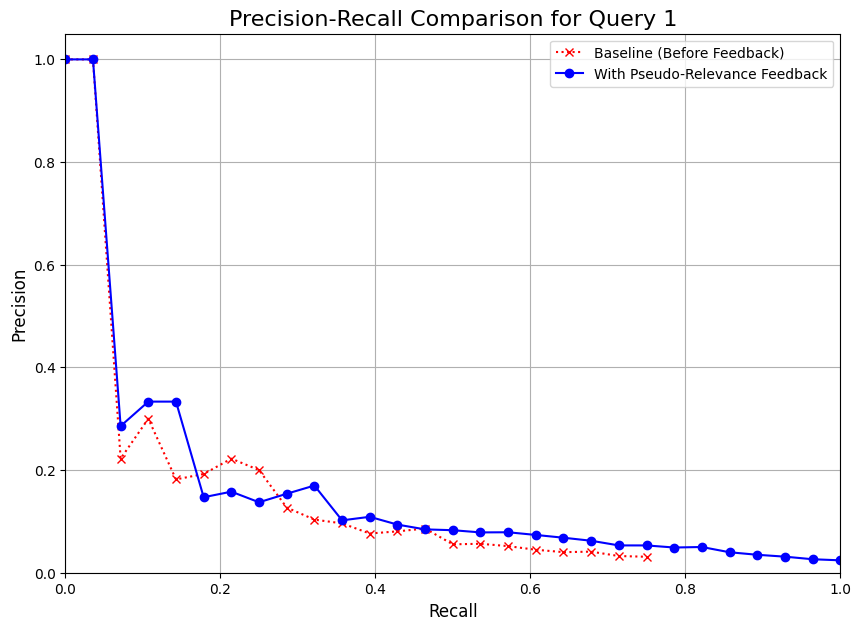

In [31]:

plot_feedback_comparison(
    query_id=1, 
    n_feedback=3,
    queries=queries, 
    relevance_data=relevance_data, 
    document_vectors=document_vectors,
    idf_scores=idf_scores
)
